# Telecom Churn Analysis & Modeling

## Overview

This project utilizes a dataset of customers from the telecommunications company SyriaTel, analyzing the churn rate of customers (number of customers that stop doing business with the company) by identifying patterns amongst customer features. Additionally, several classification models are built and tuned, then compared to choose the best model for predicting whether customers will stop doing business.   

## Business Problem

The telecom company SyriaTel is concerned with their profits related to customer retention. They want to reduce the amount of money lost because of customers that don't remain with the company for very long. The task is to build a classifier to predict if a customer will soon stop doing business with SyriaTel, by looking for any predictable patterns. 

## Data Understanding

The dataset used for this project is a csv file ("churn_data.csv"), containing over 3,000 customer records and 21 columns. These columns include information on whether they have an international plan or voice mail plan, the totality of calls made and minutes spent on the phone, and the number of calls made to customer service. The target feature is the final column labeled "churn", a binary column indicating whether or not they stopped doing business with the company.  

### Import Libraries

First thing we did was import the necessary libraries for analysis, visualization, preprocessing data, and building models, as well as ignore warnings. 

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss, roc_curve, mean_squared_error, auc, accuracy_score, f1_score, recall_score, roc_auc_score, precision_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

Then we assigned a random state variable to generate the same results.

In [2]:
#set a random state variable
STATE = 42

### Data Inspection

We proceeded to load the csv dataset, then look at the shape, size, column names and data types, as well as check for missing or duplicate entries.

In [3]:
#load the dataset, column names are in the second row
df = pd.read_csv('churn_data.csv', header=1)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.shape

(3333, 21)

In [5]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [6]:
#check the dtype of each column. There are no missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [7]:
#check for duplicates, which there are none
df.duplicated().sum()

0

## EDA (Exploratory Data Analysis)

### Target Feature Analysis 

We checked the value counts of our target feature, the "churn" column. We found that there is a great imbalance between False and True values, meaning the vast majority of customers in this dataset have not ceased business, as indicated in a bar graph depicting the value counts as percentages. 

In [8]:
#check the value counts of the churn column
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [9]:
#convert the churn counts into percentages in a variable called churn_rate
churn_rate = df['churn'].value_counts() / len(df['churn']) * 100 
churn_rate

False    85.508551
True     14.491449
Name: churn, dtype: float64

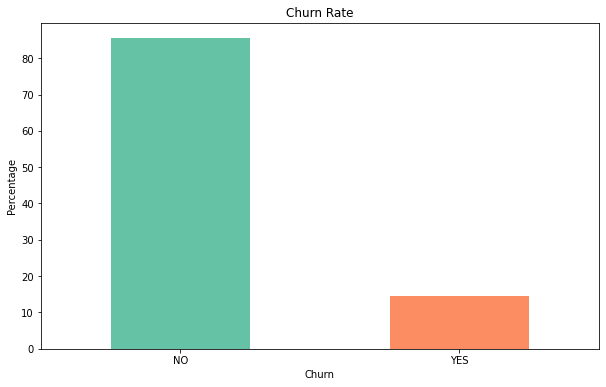

In [10]:
#plot the churn rate and design
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = sns.color_palette('Set2')
churn_rate.plot(kind='bar', ax=ax, color=colors)

#set and format the labels
ax.set_xlabel('Churn')
ax.set_ylabel('Percentage')
ax.set_title('Churn Rate')
ax.set_xticklabels(['NO', 'YES'], rotation=0)

plt.show()

### Target Feature Analysis by Category 

We separated categoric and numeric columns into variables, then proceeded to graph the churn results by category.

In [11]:
#separate categoric and numeric columns into variables
categoric = ['state', 'area code', 'voice mail plan', 'international plan']
numeric = []
for c in df.columns:
    if c not in categoric:
        numeric.append(c)
        
#remove phone number column from the numeric list
numeric.remove('phone number')

First we graphed each categoric column against the churn results. Whether a customer has a voicemail plan seemed to be a significant factor, as well as possibly having an international plan and their area code.

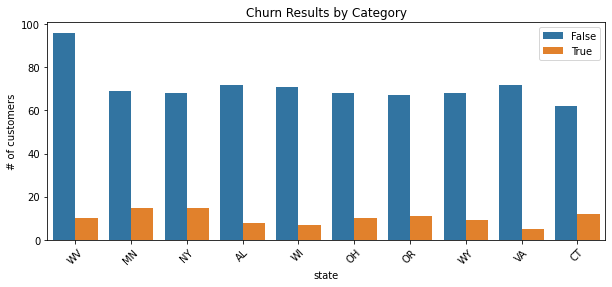

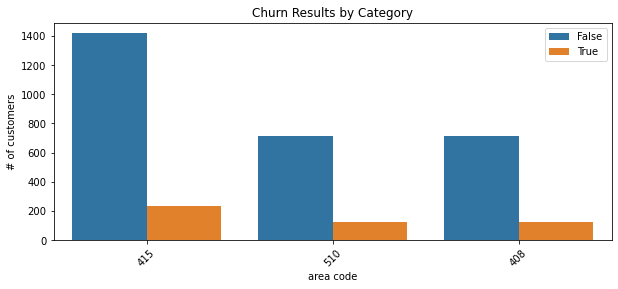

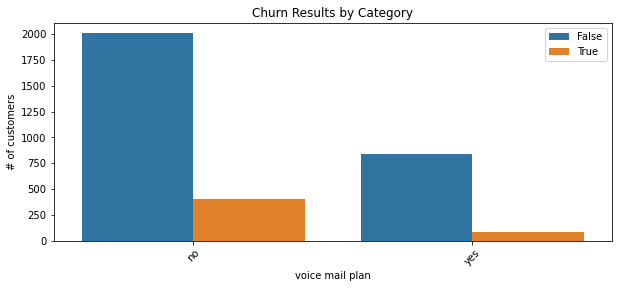

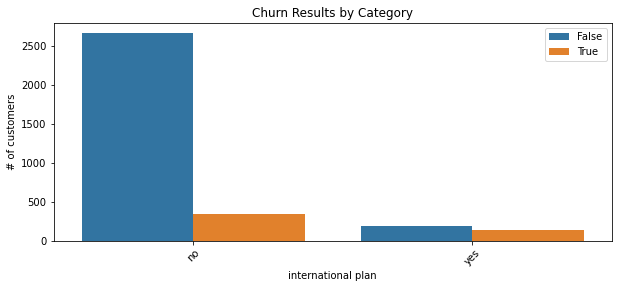

In [12]:
#graph the categoric columns and their churn outcomes
for cat in categoric:
    plt.figure(figsize=(10,4))
    sns.countplot(x=cat, hue="churn", data=df, order= df[cat].value_counts().iloc[0:10].index)
    plt.xticks(rotation=45)
    plt.ylabel('# of customers')
    plt.title('Churn Results by Category')
    plt.legend(loc="upper right")
    plt.show()

### Churn Rate by State

We also looked at the top states of churned customers by grouping them and graphing the top 10 results, first as a total sum, then by average. While Texas has the most churned customers, the rate is actually highest in California and New Jersey.

In [13]:
#group the customers who've dropped the company by state and sort the values in descending order
churn_per_state = df.groupby('state')['churn'].sum().sort_values(ascending=False)
churn_per_state.head()

state
TX    18
NJ    18
MD    17
MI    16
NY    15
Name: churn, dtype: int64

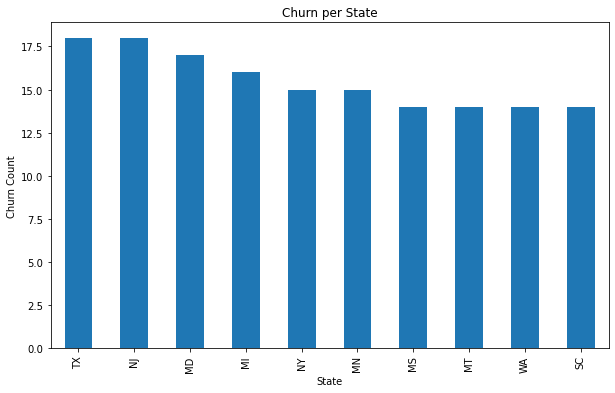

In [14]:
#graph the top 10 churned customers by state
plt.figure(figsize=(10, 6))
churn_per_state[:10].plot(kind='bar')

#set the labels
plt.xlabel('State')
plt.ylabel('Churn Count')
plt.title('Churn per State')

plt.show()

In [15]:
#group the churned customers by state and convert into the mean, sorting the results in descending order
churn_rate_per_state = df.groupby('state')['churn'].mean().sort_values(ascending=False)
churn_rate_per_state.head()

state
CA    0.264706
NJ    0.264706
TX    0.250000
MD    0.242857
SC    0.233333
Name: churn, dtype: float64

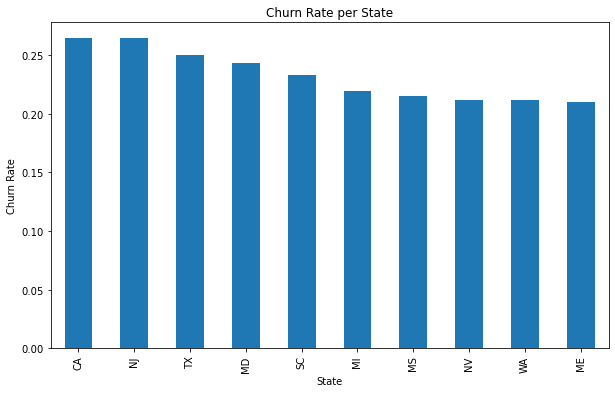

In [16]:
#graph the 10 highest churn rates by state
plt.figure(figsize=(10, 6))
churn_rate_per_state[:10].plot(kind='bar')

#set the labels
plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.title('Churn Rate per State')

plt.show()

### Churn Rate on One Plot

We graphed the categories against the churn rate, not just the total sum, onto one plot to visualize at once. Here it seems that the biggest categoric indicators of a customer ceasing business is if they did not have a voicemail plan, and also if they did in fact have an international plan, which is interesting.

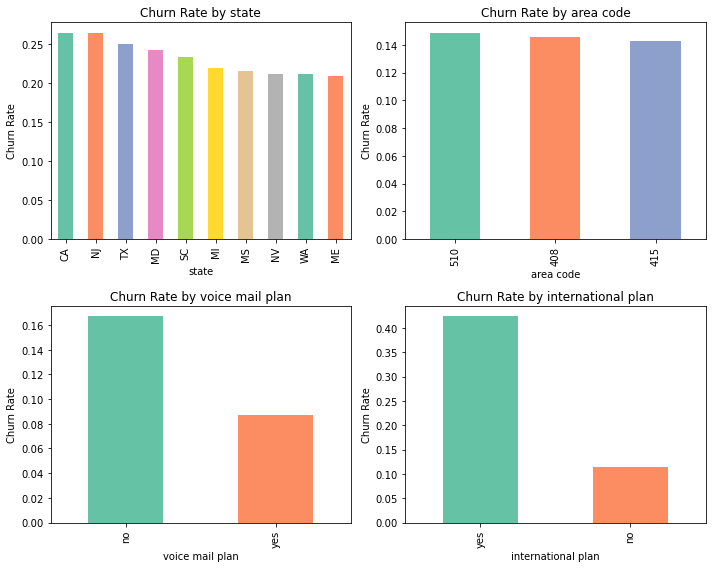

In [17]:
#plot a figure and multiple axes
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax = ax.ravel()

#iterate over categoric columns
for i, column in enumerate(categoric):
    
    # Calculate the churn rate for each unique value in the column
    churn_rates = df.groupby(column)['churn'].mean().sort_values(ascending=False).head(10)

    # Graph the churn rates
    churn_rates.plot(kind='bar', ax=ax[i], color=sns.color_palette("Set2"))
    
    #set the labels
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(f'Churn Rate by {column}')
    
    
plt.tight_layout()
plt.show()

### Distribution Curves of Numeric Columns 

We graphed the distribution curve of every numeric column onto one plot. Most have a normal distribution (with some skewness to the right in total international calls and number of voicemail messages), but customer service calls has several modes.

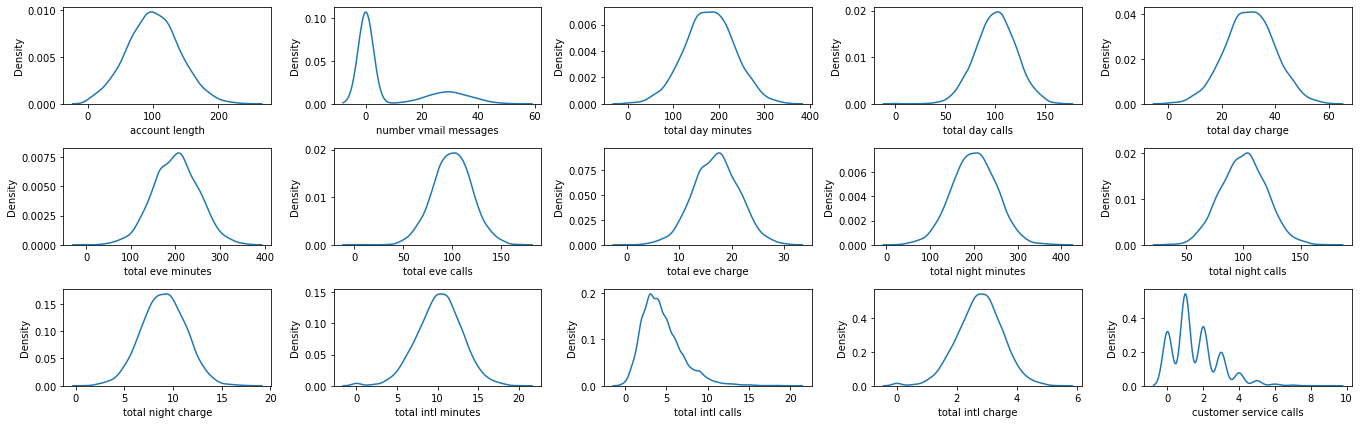

In [18]:
#set a plot and multiple axes
fig, ax = plt.subplots(3,5,figsize=(19,6))
ax = ax.flatten()

#iterate over the numeric columns and plot distribution curves
for i, j in enumerate(numeric):
    if j != 'churn':
        sns.kdeplot(df[j],ax=ax[i]);

plt.tight_layout()
plt.show()

### Box Plot

We graphed a box plot of several of the numeric columns and the total churn values. The strongest indicator amongst them was the number of customer service calls. Two or more calls to customer service was a clear indicator of a likelihood that they would soon stop doing business with the company.

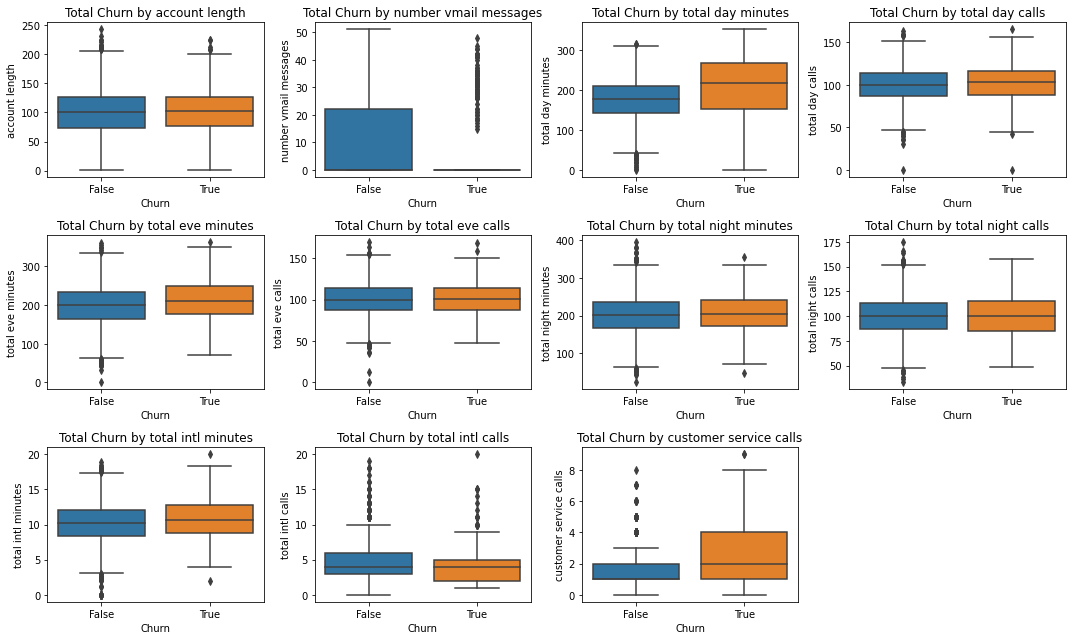

In [19]:
#create a sublist of numeric columns
my_list = ['total intl charge', 'total night charge', 'total eve charge', 'total day charge', 'churn']
more_numeric = [item for item in numeric if item not in my_list]

#plot a figure and multiple axes
fig, ax = plt.subplots(3, 4, figsize=(15,9))
ax = ax.ravel()

#iterate over numeric columns
for i, column in enumerate(more_numeric):
    
    # Graph a boxplot of the total churn against each numeric column of the sublist
    sns.boxplot(x='churn', y=column, ax=ax[i], data=df)
    
    #set the labels
    ax[i].set_xlabel('Churn')
    ax[i].set_ylabel(column)
    ax[i].set_title(f'Total Churn by {column}')

#remove last empty graph
fig.delaxes(ax[-1])

plt.tight_layout()
plt.show()

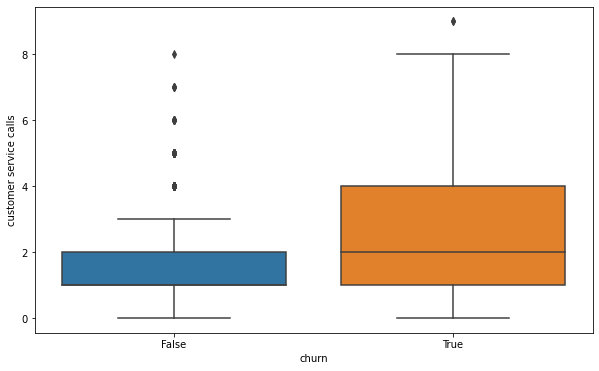

In [20]:
#graph a boxplot to check the typical number of customer service calls for customers that stay vs leave
plt.figure(figsize=(10,6))
sns.boxplot(x='churn', y='customer service calls', data=df)
plt.show()

### Correlation Matrix

We graphed a correlation matrix of all of the numeric columns. There was a perfect correlation between total minutes and total charge, as well as a high correlation between total domestic calls and total calls at different parts of the day. This can risk multicollinearity, so we decided to remove several of the redundant columns

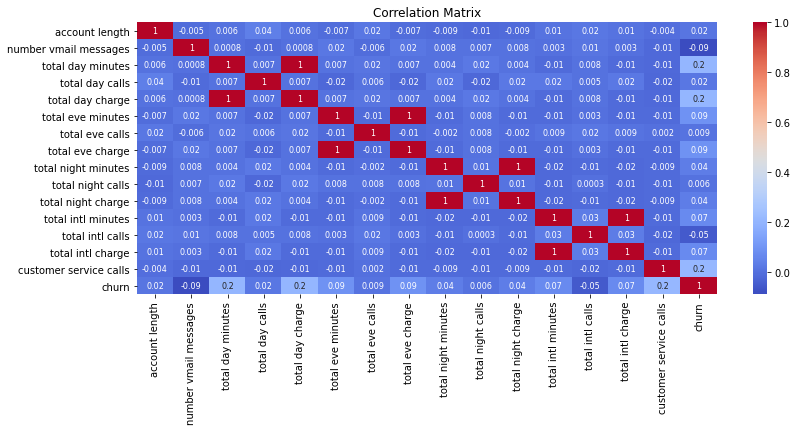

In [21]:
# Compute the correlation matrix
correlation_matrix = df[numeric].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(13, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.0g', annot_kws={"size": 8})
plt.title('Correlation Matrix')


plt.show()

We then proceed to drop the columns that have low correlation to churn or high correlation to other columns. 

In [22]:
#drop perfectly correlated columns
df = df.drop(columns=['total day charge', 'total eve charge', 'total night charge', 'total intl charge', 'total eve calls', 'total night calls'])
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total night minutes,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,244.7,10.0,3,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,254.4,13.7,3,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,162.6,12.2,5,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,196.9,6.6,7,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,186.9,10.1,3,3,False


## Data Preprocessing

### Converting Values

We converted churn to integers of 1 and 0, and dropped the phone number column.

In [23]:
#drop phone number
df = df.drop(columns=['phone number'])

In [24]:
#convert churn of True and False to 1 and 0
df['churn'] = df['churn'].astype(int)
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total night minutes,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,no,yes,25,265.1,110,197.4,244.7,10.0,3,1,0
1,OH,107,415,no,yes,26,161.6,123,195.5,254.4,13.7,3,1,0
2,NJ,137,415,no,no,0,243.4,114,121.2,162.6,12.2,5,0,0
3,OH,84,408,yes,no,0,299.4,71,61.9,196.9,6.6,7,2,0
4,OK,75,415,yes,no,0,166.7,113,148.3,186.9,10.1,3,3,0


We also converted yes and no for voice mail plan and international plan to 1 and 0.

In [25]:
#replace yes and no with 1 and 0
df['international plan'] = df['international plan'].replace({'yes': 1, 'no': 0})
df['voice mail plan'] = df['voice mail plan'].replace({'yes': 1, 'no': 0})
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total night minutes,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,0,1,25,265.1,110,197.4,244.7,10.0,3,1,0
1,OH,107,415,0,1,26,161.6,123,195.5,254.4,13.7,3,1,0
2,NJ,137,415,0,0,0,243.4,114,121.2,162.6,12.2,5,0,0
3,OH,84,408,1,0,0,299.4,71,61.9,196.9,6.6,7,2,0
4,OK,75,415,1,0,0,166.7,113,148.3,186.9,10.1,3,3,0


### Train Test Split

We set up a train test split with the newly selected features and target.

In [26]:
#set up datasets for modeling
X = df.drop(['churn'], axis=1)
y = df['churn']

In [27]:
#create a train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=STATE)

### Encoding 

We used OneHotEncoder on the categorical columns of the data.

In [28]:
# Perform one-hot encoding on categorical features in both train and test sets
X_train = pd.get_dummies(X_train, columns=['state', 'area code'])
X_test = pd.get_dummies(X_test, columns=['state', 'area code'])

X_train.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total night minutes,total intl minutes,total intl calls,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510
367,45,0,0,0,78.2,127,253.4,255.0,18.0,3,...,0,0,0,0,0,0,0,0,1,0
3103,115,0,0,0,195.9,111,227.0,313.2,13.2,1,...,0,0,0,0,0,0,0,0,1,0
549,121,0,1,31,237.1,63,205.6,196.7,10.1,5,...,0,0,0,0,0,0,0,1,0,0
2531,180,0,0,0,143.3,134,180.5,184.2,10.1,4,...,0,0,0,0,0,0,0,0,1,0
2378,112,0,0,0,206.2,122,164.5,140.3,12.6,7,...,0,0,0,0,0,0,0,0,0,1


### Scaling

We used StandardScaler to balance the numeric columns.

In [29]:
#select numeric columns
numeric_columns = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total eve minutes', 'total night minutes', 
                  'total intl minutes', 'total intl calls', 'customer service calls']

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

# Scale numeric columns in train set
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

# Scale numeric columns in test set
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])


X_train.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total night minutes,total intl minutes,total intl calls,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510
367,0.190476,0,0,0.000000,0.217117,0.718519,0.696728,0.623453,0.900,0.166667,...,0,0,0,0,0,0,0,0,1,0
3103,0.493506,0,0,0.000000,0.555141,0.600000,0.624141,0.779989,0.660,0.055556,...,0,0,0,0,0,0,0,0,1,0
549,0.519481,0,1,0.607843,0.673464,0.244444,0.565301,0.466649,0.505,0.277778,...,0,0,0,0,0,0,0,1,0,0
2531,0.774892,0,0,0.000000,0.404078,0.770370,0.496288,0.433029,0.505,0.222222,...,0,0,0,0,0,0,0,0,1,0
2378,0.480519,0,0,0.000000,0.584721,0.681481,0.452296,0.314954,0.630,0.388889,...,0,0,0,0,0,0,0,0,0,1


### SMOTE

We used the SMOTE method to transform the imbalanced target feature 'churn'. 

In [30]:
#instantiate SMOTE
smote = SMOTE(random_state=STATE)

#fit SMOTE to the training data and transform test
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [31]:
#check the target is even
y_train_resampled.value_counts()

1    2141
0    2141
Name: churn, dtype: int64

## Modeling

### Logistic Regression

The first model we created was a logistic regression model.

In [32]:
#create and fit a baseline logistic regression model
logreg = LogisticRegression(random_state=STATE)
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [33]:
# Obtain predictions on training set
y_train_pred = logreg.predict(X_train)

# Obtain predictions on test set
y_test_pred = logreg.predict(X_test)

### Features

We graphed the features based on their importance.

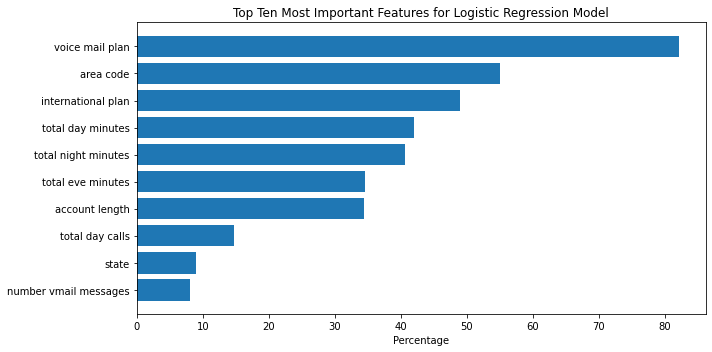

In [34]:
#grab the features' importances
feature_importance = abs(logreg.coef_[0])

#convert to percentage and sort
feature_importance = 100.0 * (feature_importance / feature_importance.max())[0:10]
sorted_list = np.argsort(feature_importance)[::-1][:10]
importance = np.arange(sorted_list.shape[0], 0, -1)  

#plot graph
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(importance, feature_importance[sorted_list], align='center')
plt.title('Top Ten Most Important Features for Logistic Regression Model')
ax.set_xlabel('Percentage')
ax.set_yticks(importance)
ax.set_yticklabels(np.array(X.columns)[sorted_list])

plt.tight_layout()
plt.show()

### Logistic Regression Metrics

We looked at the metrics for this model.

In [35]:
#print metrics
print("**************** LOGISTIC REGRESSION MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_test_pred),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_test_pred),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_test_pred),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_test_pred),4))


**************** LOGISTIC REGRESSION MODEL RESULTS **************** 
Accuracy score for testing set:  0.8106
F1 score for testing set:  0.5062
Recall score for testing set:  0.648
Precision score for testing set:  0.4154


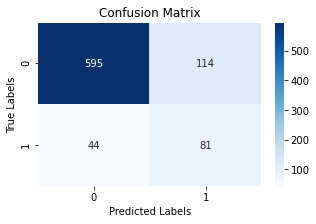

In [36]:
#confusion matrix
cfm = confusion_matrix(y_test, y_test_pred)

#plot graph
fig, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

As you can see, the F1 and Precision scores are concerning. The matrix also shows more false negatives than true negatives.

### Decision Tree Classifier

We then set up a decision tree classifier model.

In [37]:
# Instantiate the Decision Tree classifier with limited depth
tree = DecisionTreeClassifier(random_state=STATE)

# Fit the model to the training data
tree.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_tree = tree.predict(X_test)

### Features

Graphed the features based on importance, just like the previous model.

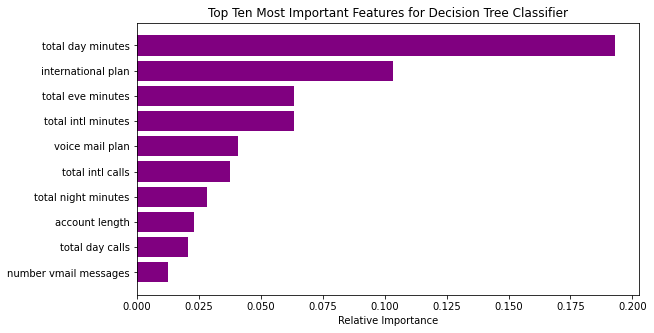

In [38]:
#get the feature names
feat_names = list(X_train.columns)

#calculate their importance
importance = tree.feature_importances_[0:10]
index = np.argsort(importance)

#plot a graph
plt.figure(figsize=(9,5))
plt.title('Top Ten Most Important Features for Decision Tree Classifier')
plt.barh(range(len(index)), importance[index], color='purple')
plt.yticks(range(len(index)), [feat_names[i] for i in index])
plt.xlabel('Relative Importance')
plt.show()

### Decision Tree Metrics

We now printed the metrics of the Decision Tree Classifier.

In [39]:
#print metrics
print("**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_tree),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_tree),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_tree),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_tree),4))

**************** DECISION TREE CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.8789
F1 score for testing set:  0.6354
Recall score for testing set:  0.704
Precision score for testing set:  0.5789


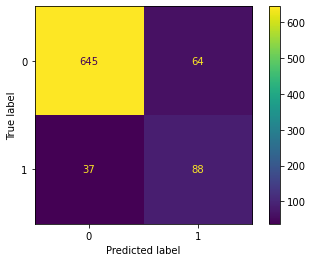

In [40]:
#confusion matrix for decision tree
cfm_tree = confusion_matrix(y_test, y_pred_tree, labels=tree.classes_)

#plot matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cfm_tree, display_labels=tree.classes_)
disp.plot()
plt.show()

These results were more promising than the logistic regression model. The scores are higher, and the true negatives and positives outweigh the false ones.

## Model Comparison

We proceeded to compare the two models that we created.

### ROC Curve

First we graphed the ROC curve of the two baseline models and noted their AUC. Logistic Regression was just slightly higher.

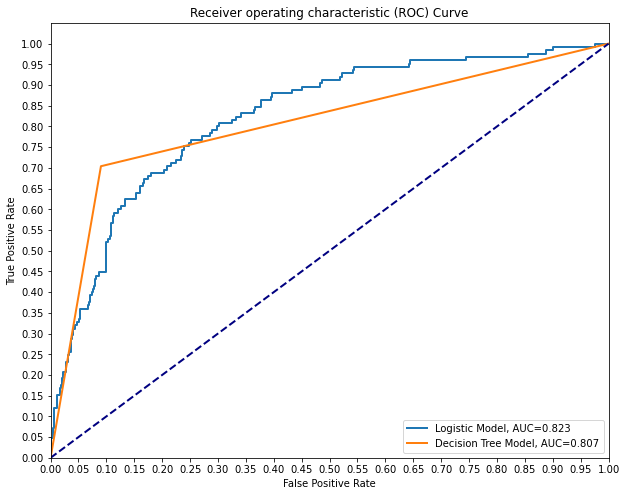

In [41]:
#set up plot
fig, ax = plt.subplots(figsize=(10, 8))

#set up predictions for graph
y_proba = logreg.predict_proba(X_test)[:, 1]
y_prob = tree.predict_proba(X_test)[:, 1]

#create roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_prob)

#plot the curves
lw = 2
ax.plot(fpr, tpr, lw=lw, label="Logistic Model, AUC={:.3f}".format(auc(fpr, tpr)))
ax.plot(fpr_tree, tpr_tree, lw=lw, label='Decision Tree Model, AUC={:.3f}'.format(auc(fpr_tree, tpr_tree)))

#set labels and regular line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show();

### Metric Scores Graphs

We looped through and graphed the four metrics of accuracy, F1, precision, and recall onto one plot. The decision tree model out performed the logistic regression model in all four metrics. 

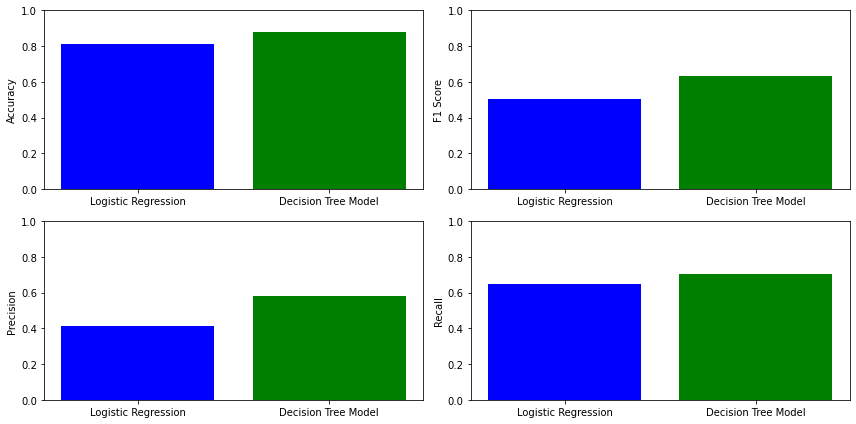

In [42]:
#calculate score
accuracy_scores = [accuracy_score(y_test, y_test_pred), accuracy_score(y_test, y_pred_tree)]
f1_scores = [f1_score(y_test, y_test_pred), f1_score(y_test, y_pred_tree)]
precision_scores = [precision_score(y_test, y_test_pred), precision_score(y_test, y_pred_tree)]
recall_scores = [recall_score(y_test, y_test_pred), recall_score(y_test, y_pred_tree)]

#create an array for model names
model_names = ['Logistic Regression', 'Decision Tree Model']

#set up plot
fig, ax = plt.subplots(2,2,figsize=(12,6))

# Loop through scores and plot on the corresponding axis
scores = [accuracy_scores, f1_scores, precision_scores, recall_scores]
score_names = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

for i in range(2):
    for j in range(2):
        ax[i, j].bar(model_names, scores[i*2+j], color=['blue', 'green'])
        ax[i, j].set_ylabel(score_names[i*2+j])
        ax[i, j].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## Hyperparameter Tuning Decision Tree Model

Based on the numerous metrics we visualized, the decision tree classifier was the better model so we chose that model. Finally, we tuned this model to optimize its performance.

### Max Depth

First we iterated through to find the optimal maximum depth value.

Maximum Test AUC: 0.853675599435825
Corresponding Depth: 9


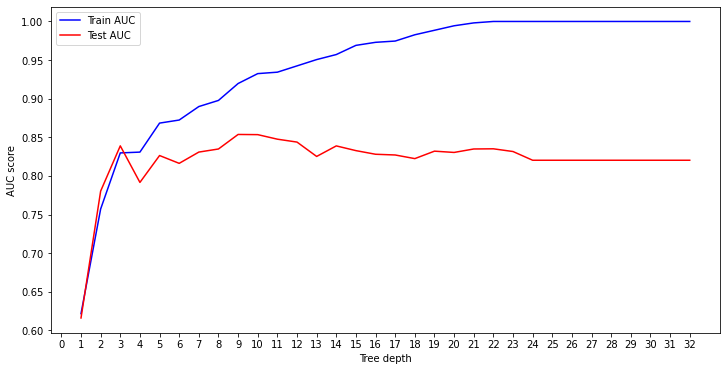

In [43]:
#set a list of max depths and arrays for train and tets
max_depths = list(range(1, 33))
train_results = []
test_results = []

# Variables to store the maximum test AUC and its corresponding depth
max_test_auc = 0
optimal_depth = 0

#iterate through list and append results
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=STATE)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

    # Check if the current test AUC is the maximum so far
    if roc_auc > max_test_auc:
        max_test_auc = roc_auc
        optimal_depth = max_depth

# Print the maximum test AUC and its corresponding depth
print("Maximum Test AUC:", max_test_auc)
print("Corresponding Depth:", optimal_depth)

#plot graph
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')

# Set custom x-ticks from 0 to the maximum depth
plt.xticks(range(0, max_depths[-1] + 1))

plt.legend()
plt.show()

### Min Samples Split

Then we did the same to find the ideal minimum samples split.

Maximum Test AUC: 0.8308885754583921
Corresponding Split: 0.2


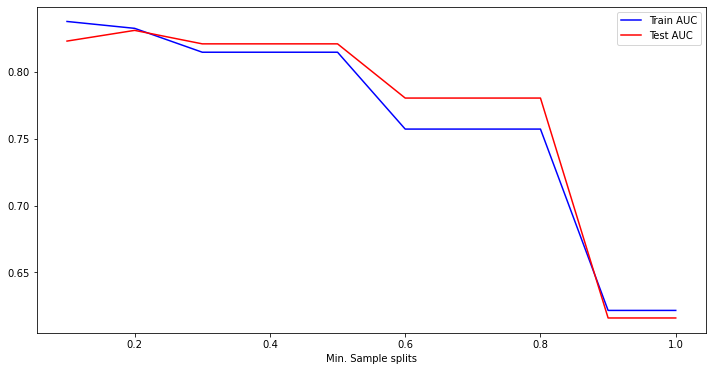

In [44]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

# Variables to store the maximum test AUC and its corresponding min samples split
max_test_auc = 0
optimal_split = 0

#iterate over split samples to determine best value
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=STATE)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    # Check if the current test AUC is the maximum so far
    if roc_auc > max_test_auc:
        max_test_auc = roc_auc
        optimal_split = min_samples_split

# Print the maximum test AUC and its corresponding split
print("Maximum Test AUC:", max_test_auc)
print("Corresponding Split:", optimal_split)

#plot graph
plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

### Min Sample Leafs

Then we did the same to find the ideal minimum sample leafs.

Maximum Test AUC: 0.7803215796897038
Corresponding Leafs: 0.1


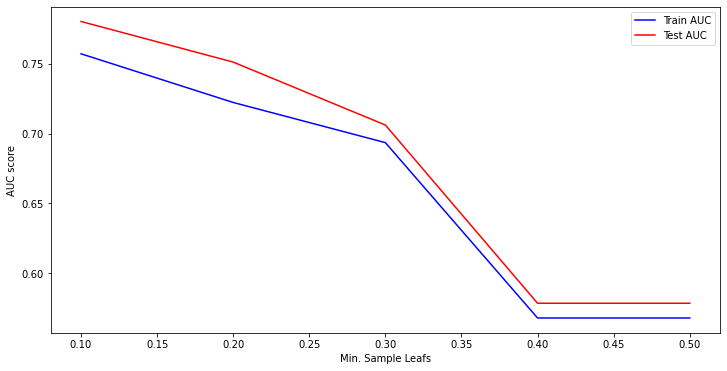

In [45]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

# Variables to store the maximum test AUC and its corresponding sample leafs
max_test_auc = 0
optimal_leafs = 0

#iterate over the samples and find the optimal value for leafs
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=STATE)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    # Check if the current test AUC is the maximum so far
    if roc_auc > max_test_auc:
        max_test_auc = roc_auc
        optimal_leafs = min_samples_leaf

# Print the maximum test AUC and its corresponding leafs
print("Maximum Test AUC:", max_test_auc)
print("Corresponding Leafs:", optimal_leafs)
        
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

### Min Weight Fraction Leaf

We graphed the ideal value for the minimum weight fraction leaf.

Maximum Test AUC: 0.7803215796897038
Corresponding Weight: 0.1


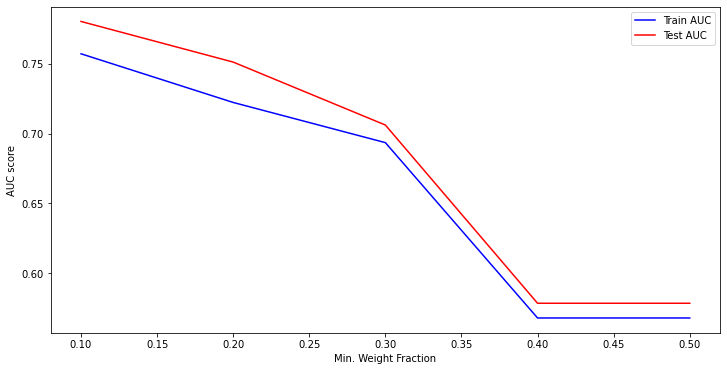

In [46]:
# Calculate the optimal value for minimum weight fraction leaf
min_weight_fractions = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

# Variables to store the maximum test AUC and its corresponding sample weight 
max_test_auc = 0
optimal_weights = 0

#iterate over the samples and find the optimal value for weight
for min_weight_fraction in min_weight_fractions:
    dt = DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=min_weight_fraction, random_state=STATE)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    # Check if the current test AUC is the maximum so far
    if roc_auc > max_test_auc:
        max_test_auc = roc_auc
        optimal_weight = min_weight_fraction

# Print the maximum test AUC and its corresponding weight
print("Maximum Test AUC:", max_test_auc)
print("Corresponding Weight:", optimal_weight)
        
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Weight Fraction')
plt.legend()
plt.show()

### Max Features

Last, we found the ideal maximum feature size.

Maximum Test AUC: 0.8539181946403386
Corresponding Leafs: 53


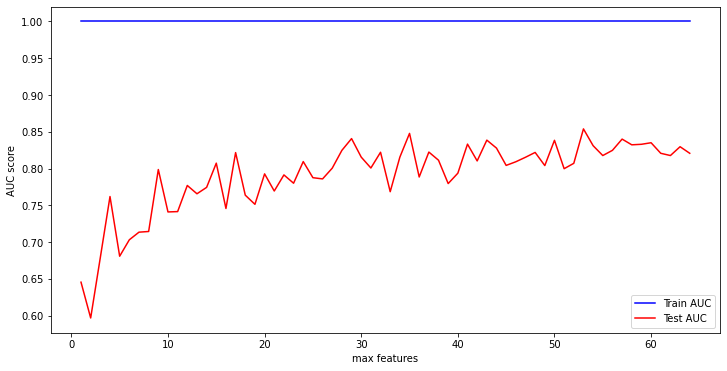

In [47]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []

# Variables to store the maximum test AUC and its corresponding features
max_test_auc = 0
optimal_features = 0

#iterate through the features values and determine best number
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=STATE)
    dt.fit(X_train_resampled, y_train_resampled)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

    # Check if the current test AUC is the maximum so far
    if roc_auc > max_test_auc:
        max_test_auc = roc_auc
        optimal_features = max_feature

# Print the maximum test AUC and its corresponding features
print("Maximum Test AUC:", max_test_auc)
print("Corresponding Leafs:", optimal_features)

#plot graph
plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

### Tuned Decision Tree Model

We then set up a new decision tree model with the tuned parameters.

In [48]:
# Instantiate the Decision Tree classifier with limited depth
tuned_tree = DecisionTreeClassifier(random_state=STATE,
                                    criterion='entropy',
                                    max_depth=9, 
                                    min_samples_leaf=0.1, 
                                    min_samples_split=0.2,
                                    max_features=50,
                                    min_weight_fraction_leaf=0.1)

# Fit the model to the training data
tuned_tree.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred_tuned = tuned_tree.predict(X_test)

### AUC and ROC Train vs Test

We then plotted the ROC Curve of the new model on the training and testing data. The testing now outperforms the training data, avoiding overfitting.

Custom Model Test AUC: 0.8205867418899858
Custom Model Train AUC: 0.8157168242271794


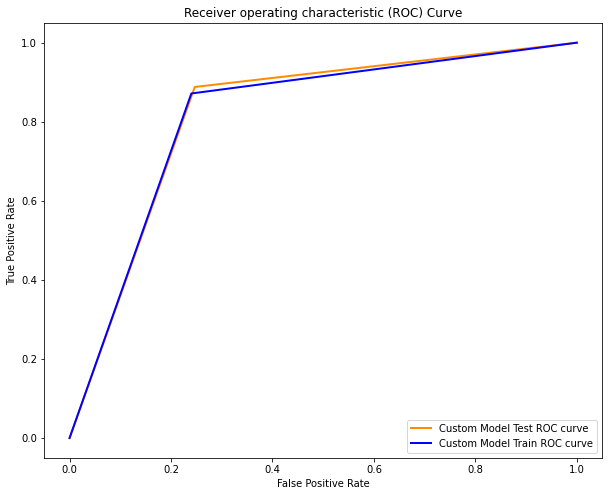

In [49]:
y_train_tuned = tuned_tree.predict(X_train)

# Initial model plots
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred_tuned)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_tuned)

#print AUC for each data split
print('Custom Model Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Custom Model Train AUC: {}'.format(auc(train_fpr, train_tpr)))

#plot graph of ROC curves
plt.figure(figsize=(10,8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Custom Model Test ROC curve')
plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Custom Model Train ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Tuned Model Metrics

We looked at the metrics again, this time for the tuned decision tree model.

In [50]:
#print metrics
print("**************** TUNED DECISION TREE CLASSIFIER MODEL RESULTS **************** ")
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_tuned),4))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_tuned),4))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_tuned),4))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_tuned),4))

**************** TUNED DECISION TREE CLASSIFIER MODEL RESULTS **************** 
Accuracy score for testing set:  0.7734
F1 score for testing set:  0.5401
Recall score for testing set:  0.888
Precision score for testing set:  0.3881


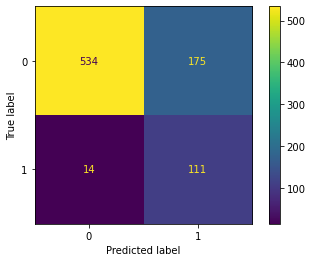

In [51]:
#confusion matrix for tuned decision tree
cfm_tuned_tree = confusion_matrix(y_test, y_pred_tuned, labels=tuned_tree.classes_)

#plot matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cfm_tuned_tree, display_labels=tuned_tree.classes_)
disp.plot()
plt.show()

The precision score is obviously quite low, but the recall score is very high, which is the more important score for this particular business problem.

## Conclusions

The conducted analysis leads to the following findings and recommendations: 

- **Customer Service Calls are a good indicator.** Generally speaking, two or more calls to customer service are a good predictor that the customer may soon cease business. 
- **Total minutes on phone calls can predict outcome.** Some of the most important features towards predicting whether a customer will cease business include the total minutes they've spent on the phone. 
- **Recall is the ideal metric for our model.** The final model we settled on has a very high recall score, indicating that it is unlikely to miss any customers that cease business with the company. 